In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import time
import seaborn as sns
import plot_init as pu
import matplotlib.pyplot as plt
import shap
import pickle
from beeswarm import beeswarm # custom implementation of shap.beeswarm

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from glob import glob
import os
import joblib
import json

/Users/damian/miniconda3/envs/paturo/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/Users/damian/miniconda3/envs/paturo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


## Loading Data

In [2]:
with open(f'../datasets/window-60-yyhat-data.json', 'r') as f:
    _speed = json.load(f)
    speeds = pd.DataFrame(_speed)
with open('../datasets/column-labels.pickle', 'rb') as f:
    column_labels = pickle.load(f)

col_map = {
        'Surrounding Commercial Pixels': 'Nearby Commercial',
        'Surrounding Residential Pixels': 'Nearby Residential', 
        'Surrounding Industrial Pixels': 'Nearby Industrial',
      }
X_test = pd.read_csv('../datasets/X_test.csv')
X_test.rename(columns=col_map, inplace = True)

data = pd.read_csv('../datasets/full-test-data.csv')
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon, data.lat))
data.crs = 'EPSG:4326'
footprints = gpd.read_file("../datasets/Building_Footprints_2015.gpkg")
footprints = footprints[footprints['OBJECTID'].notnull()]
boundaries = gpd.read_file("../datasets/cauayan_shape/Cauayan City Boundary.shp")

def clean_building_class(bclass):
    if bclass in ['residential','residential-ext']:
        return 'residential'
    elif bclass in ['industrial']:
        return 'industrial'
    elif bclass in ['commercial', 'commercial??']:
        return 'business'
    elif bclass in ['institutional', 'insitutional']:
        return 'institutional'
    
footprints['Bldg_Class'] = footprints.Bldg_Class.apply(clean_building_class)

In [3]:
def get_score(y_true, y_preds):
    return r2_score(y_true, y_preds)

def rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

def plot_lgb_yyhat(y_true, y_pred, ax, quantity_name='speed (km/hr)'):
    ax.scatter(y_true, y_pred,alpha=0.1, c='green', marker='*', s=2, lw=0)
    ax.set_xlabel(f'true {quantity_name}')
    ax.set_ylabel(f'predicted {quantity_name}')

    ax.set_ylim([i for i in ax.get_xlim()])
    
    # diagonal perfect prediction reference
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='0.3',
                   label='perfect prediction', lw=0.4, ls='--')
    ax.legend(loc='upper left', fontsize=pu.tiny, frameon=False)
    ax.set_aspect('equal')
    
    # remove spines
    sns.despine()
    
    r2 = get_score(y_true, y_pred)
    ax.annotate(f"$R^2={r2:.2f}$", size=pu.tiny, xy=(55, 0))
    
    rmse_score = rmse(y_true, y_pred)
    ax.annotate(f"$\mathrm{{RMSE}}={rmse_score:.2f}$", size=pu.tiny, xy=(55, 5))
    return ax

## Prediction scatterplot

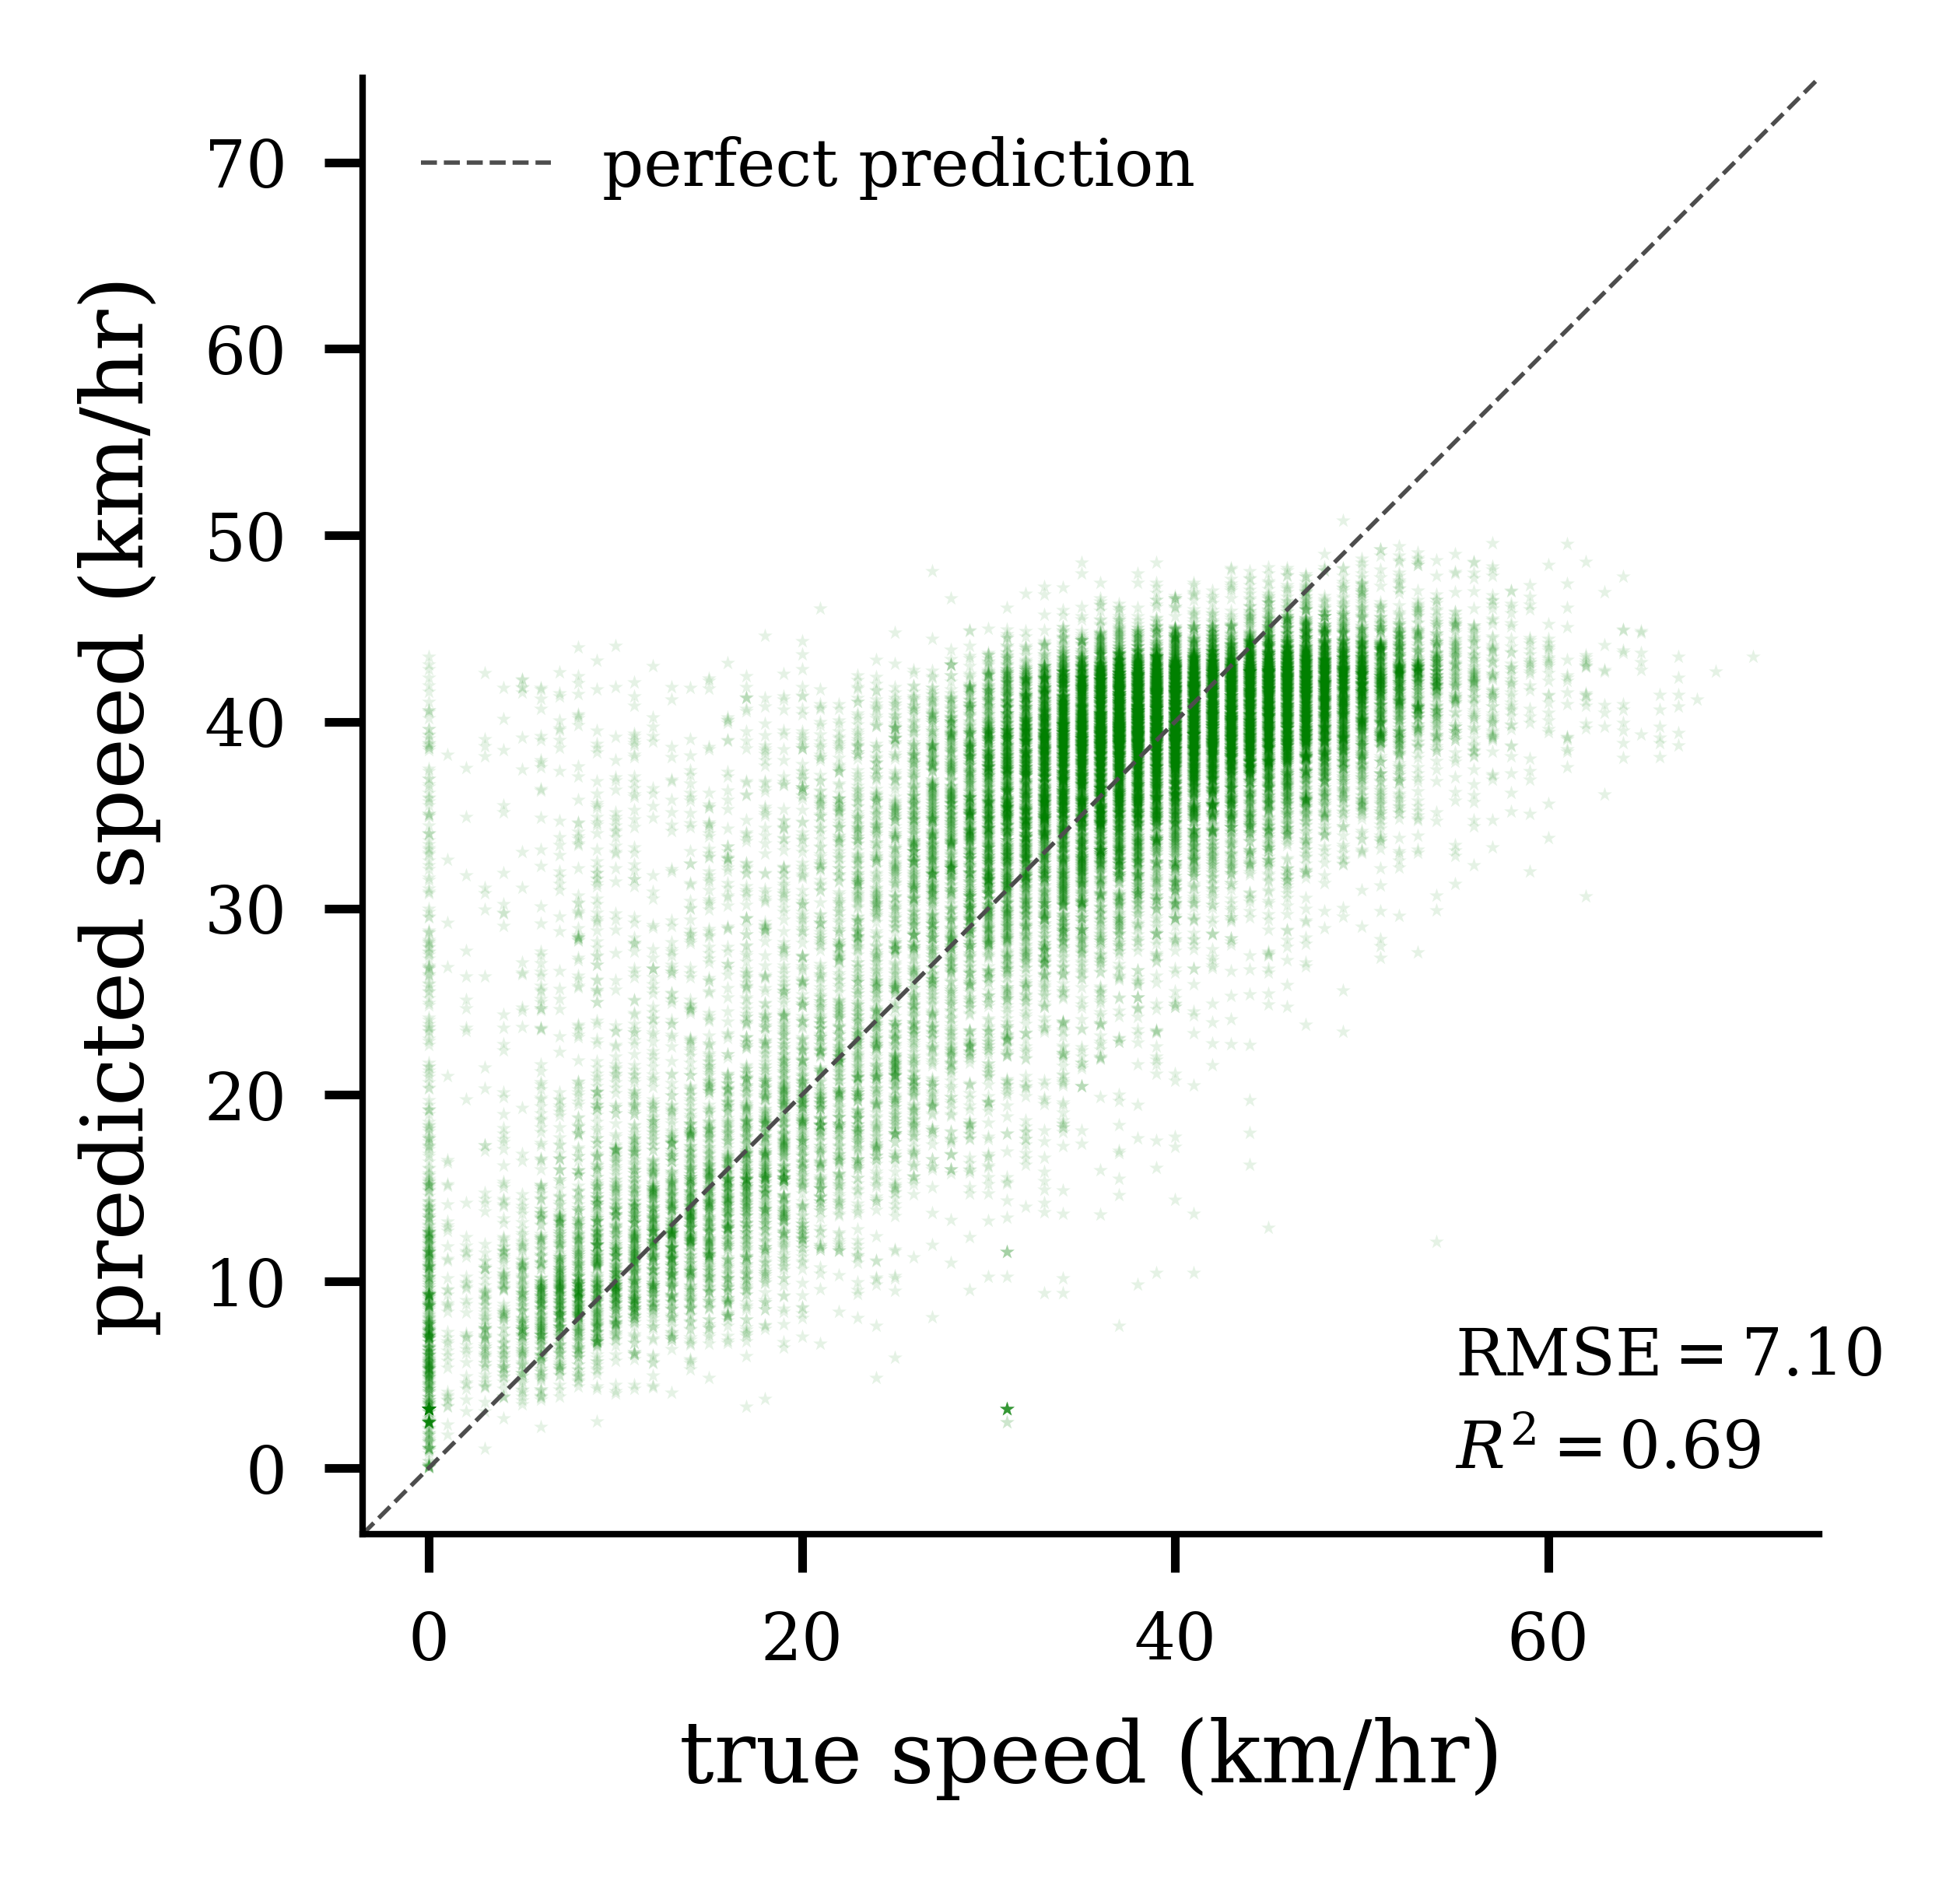

In [4]:
fig, ax = plt.subplots(1)
plot_lgb_yyhat(speeds['true'], speeds['pred'], ax)
fig.savefig('../figures/yyhat.pdf', bbox_inches='tight')

## Shap plots

In [5]:
with open('../datasets/shap-values-test.pickle', 'rb') as f:
    shap_values = pickle.load(f)

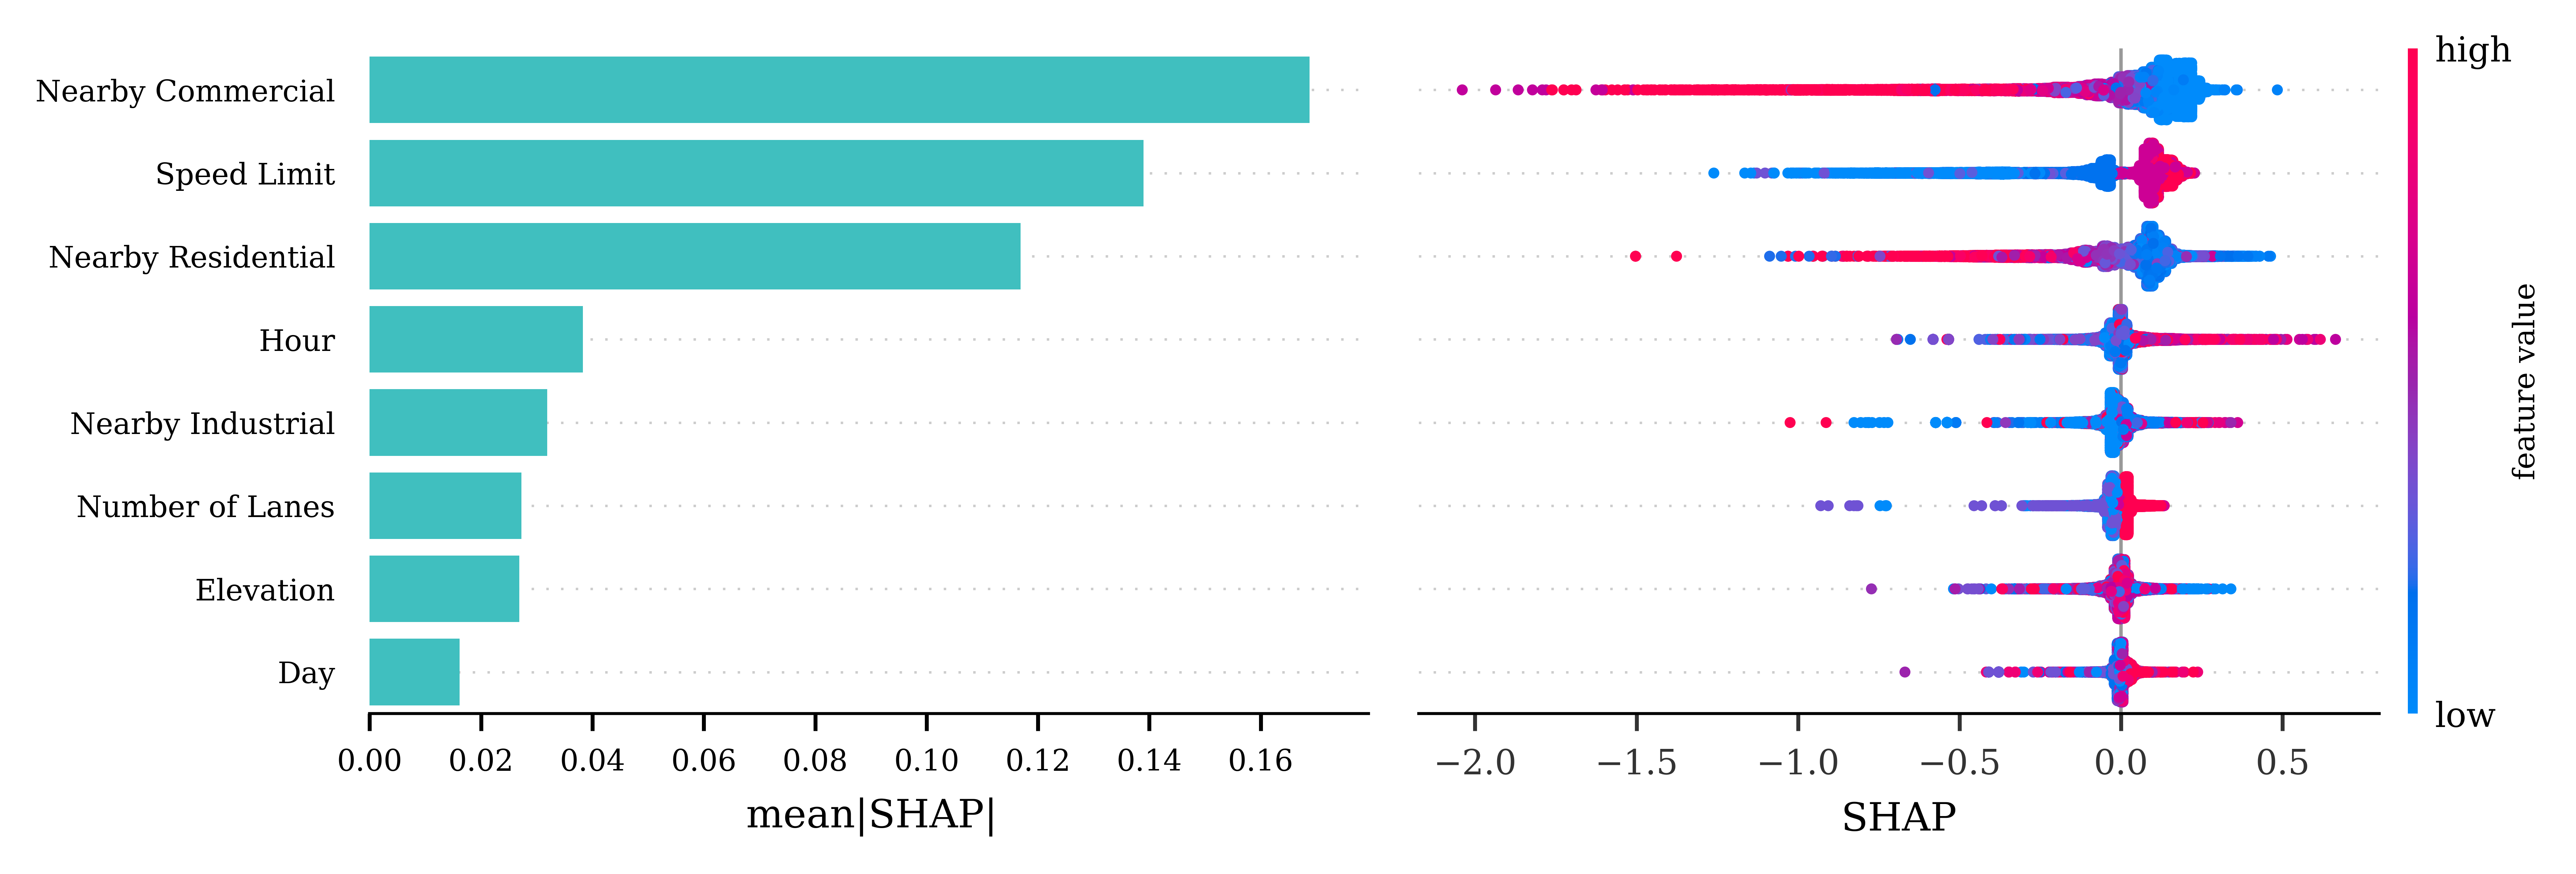

In [6]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(1,2, sharey=True, figsize=pu.figsize_mm(190, aspect=3))
ax = axes[1]

beeswarm(X_test, shap_values, ax, reverse_order=True)
feature_names = X_test.columns
feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0))


ax = axes[0]
importance = np.mean(np.abs(shap_values), axis=0)
coefs = pd.DataFrame(
    np.abs(shap_values),
    columns=feature_names,
)
## reorder columns
coefs = coefs.reindex(columns=coefs.mean(axis=0).sort_values(ascending=False).index)
sorted_features = coefs.columns
coefs = coefs.melt()

sns.barplot(ax=ax, data=coefs, x='value', y='variable', # hue='variable',
            dodge=False, orient="h", color="cyan", saturation=0.5, errwidth=0)

ax.set_ylabel(None)
ax.yaxis.set_ticks_position('none')

ax.set_xlabel(r'$\mathrm{mean}\left\|\mathrm{SHAP}\right\|$')
sns.despine(left=True, ax=ax)

for pos, i in enumerate(feature_order):
    ax.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

fig.subplots_adjust(wspace=0.05)

fig.savefig('../figures/shap.pdf', bbox_inches='tight')

## Other Visualizations

<AxesHostAxes:>

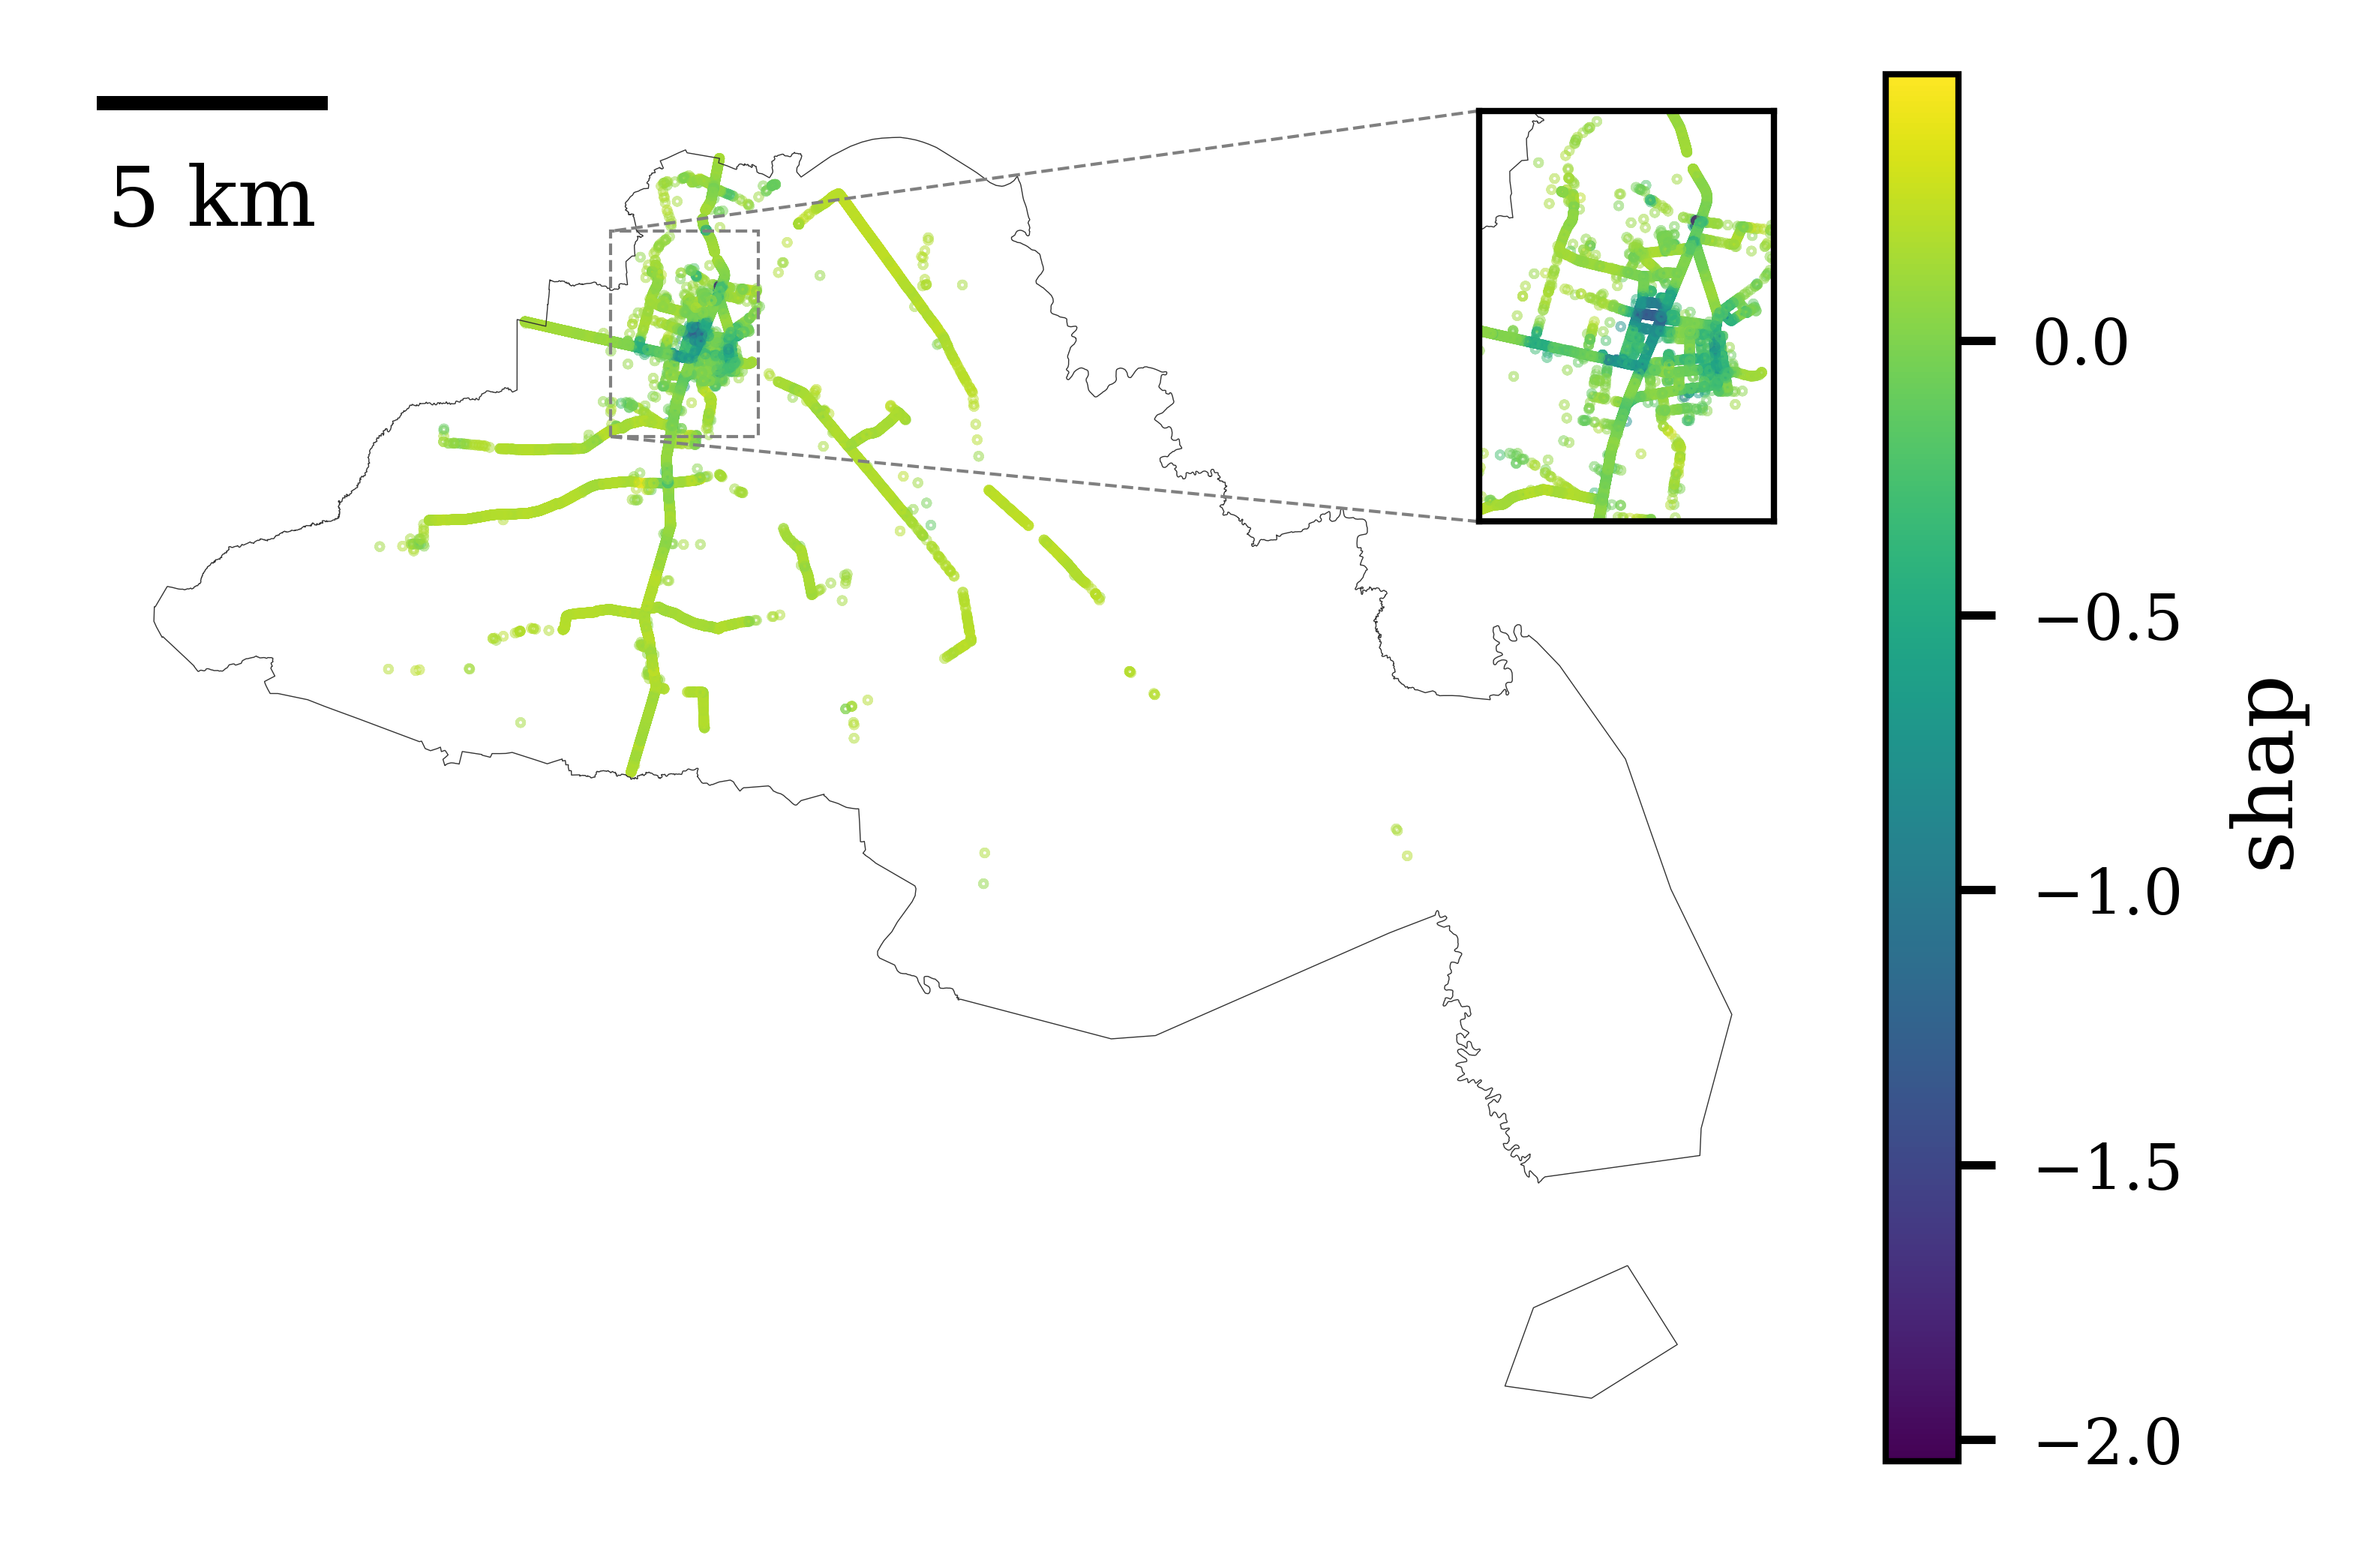

In [39]:
ms = 0.001
crs_ph = 3123
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(1)
plt_kws = {'s': ms,
           'marker': '*',
           'alpha': 0.5}

def value_map_plot(data, ax, column=None, label=None, plt_kws=None):
    x_, y_ = data.geometry[0].coords[0]
    points = gpd.GeoSeries([Point(x_, y_), Point(x_+1, y_)], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs(crs_ph) # Projected WGS 84 - meters
    distance_meters = points[0].distance(points[1])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad="2%")


    data.plot(ax=ax, column=column, legend=True, cax=cax, **plt_kws)
    ax.axis('off')

    axins = zoomed_inset_axes(ax, 2, loc=1) # zoom = 6
    data.plot(ax=axins, column=column, **plt_kws)

    # sub region of the original image
    x1, x2, y1, y2 = 121.75, 121.78, 16.92, 16.96
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    axins.set_xticks([],visible=False)
    axins.set_yticks([],visible=False)

    mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5", lw=0.3, ls='--')
    ax.add_artist(ScaleBar(distance_meters, location='upper left'))
    if label is None and column:
        label = column
    cax.set_ylabel(column)
    return ax, axins
    
data['shap'] = shap_values[:,2]
ax, axins = value_map_plot(data, ax, column='shap', label='SHAP', plt_kws=plt_kws)
boundaries.geometry.boundary.plot(ax=ax, color='0.2', lw=0.1)
boundaries.geometry.boundary.plot(ax=axins, color='0.2', lw=0.1)

<AxesHostAxes:>

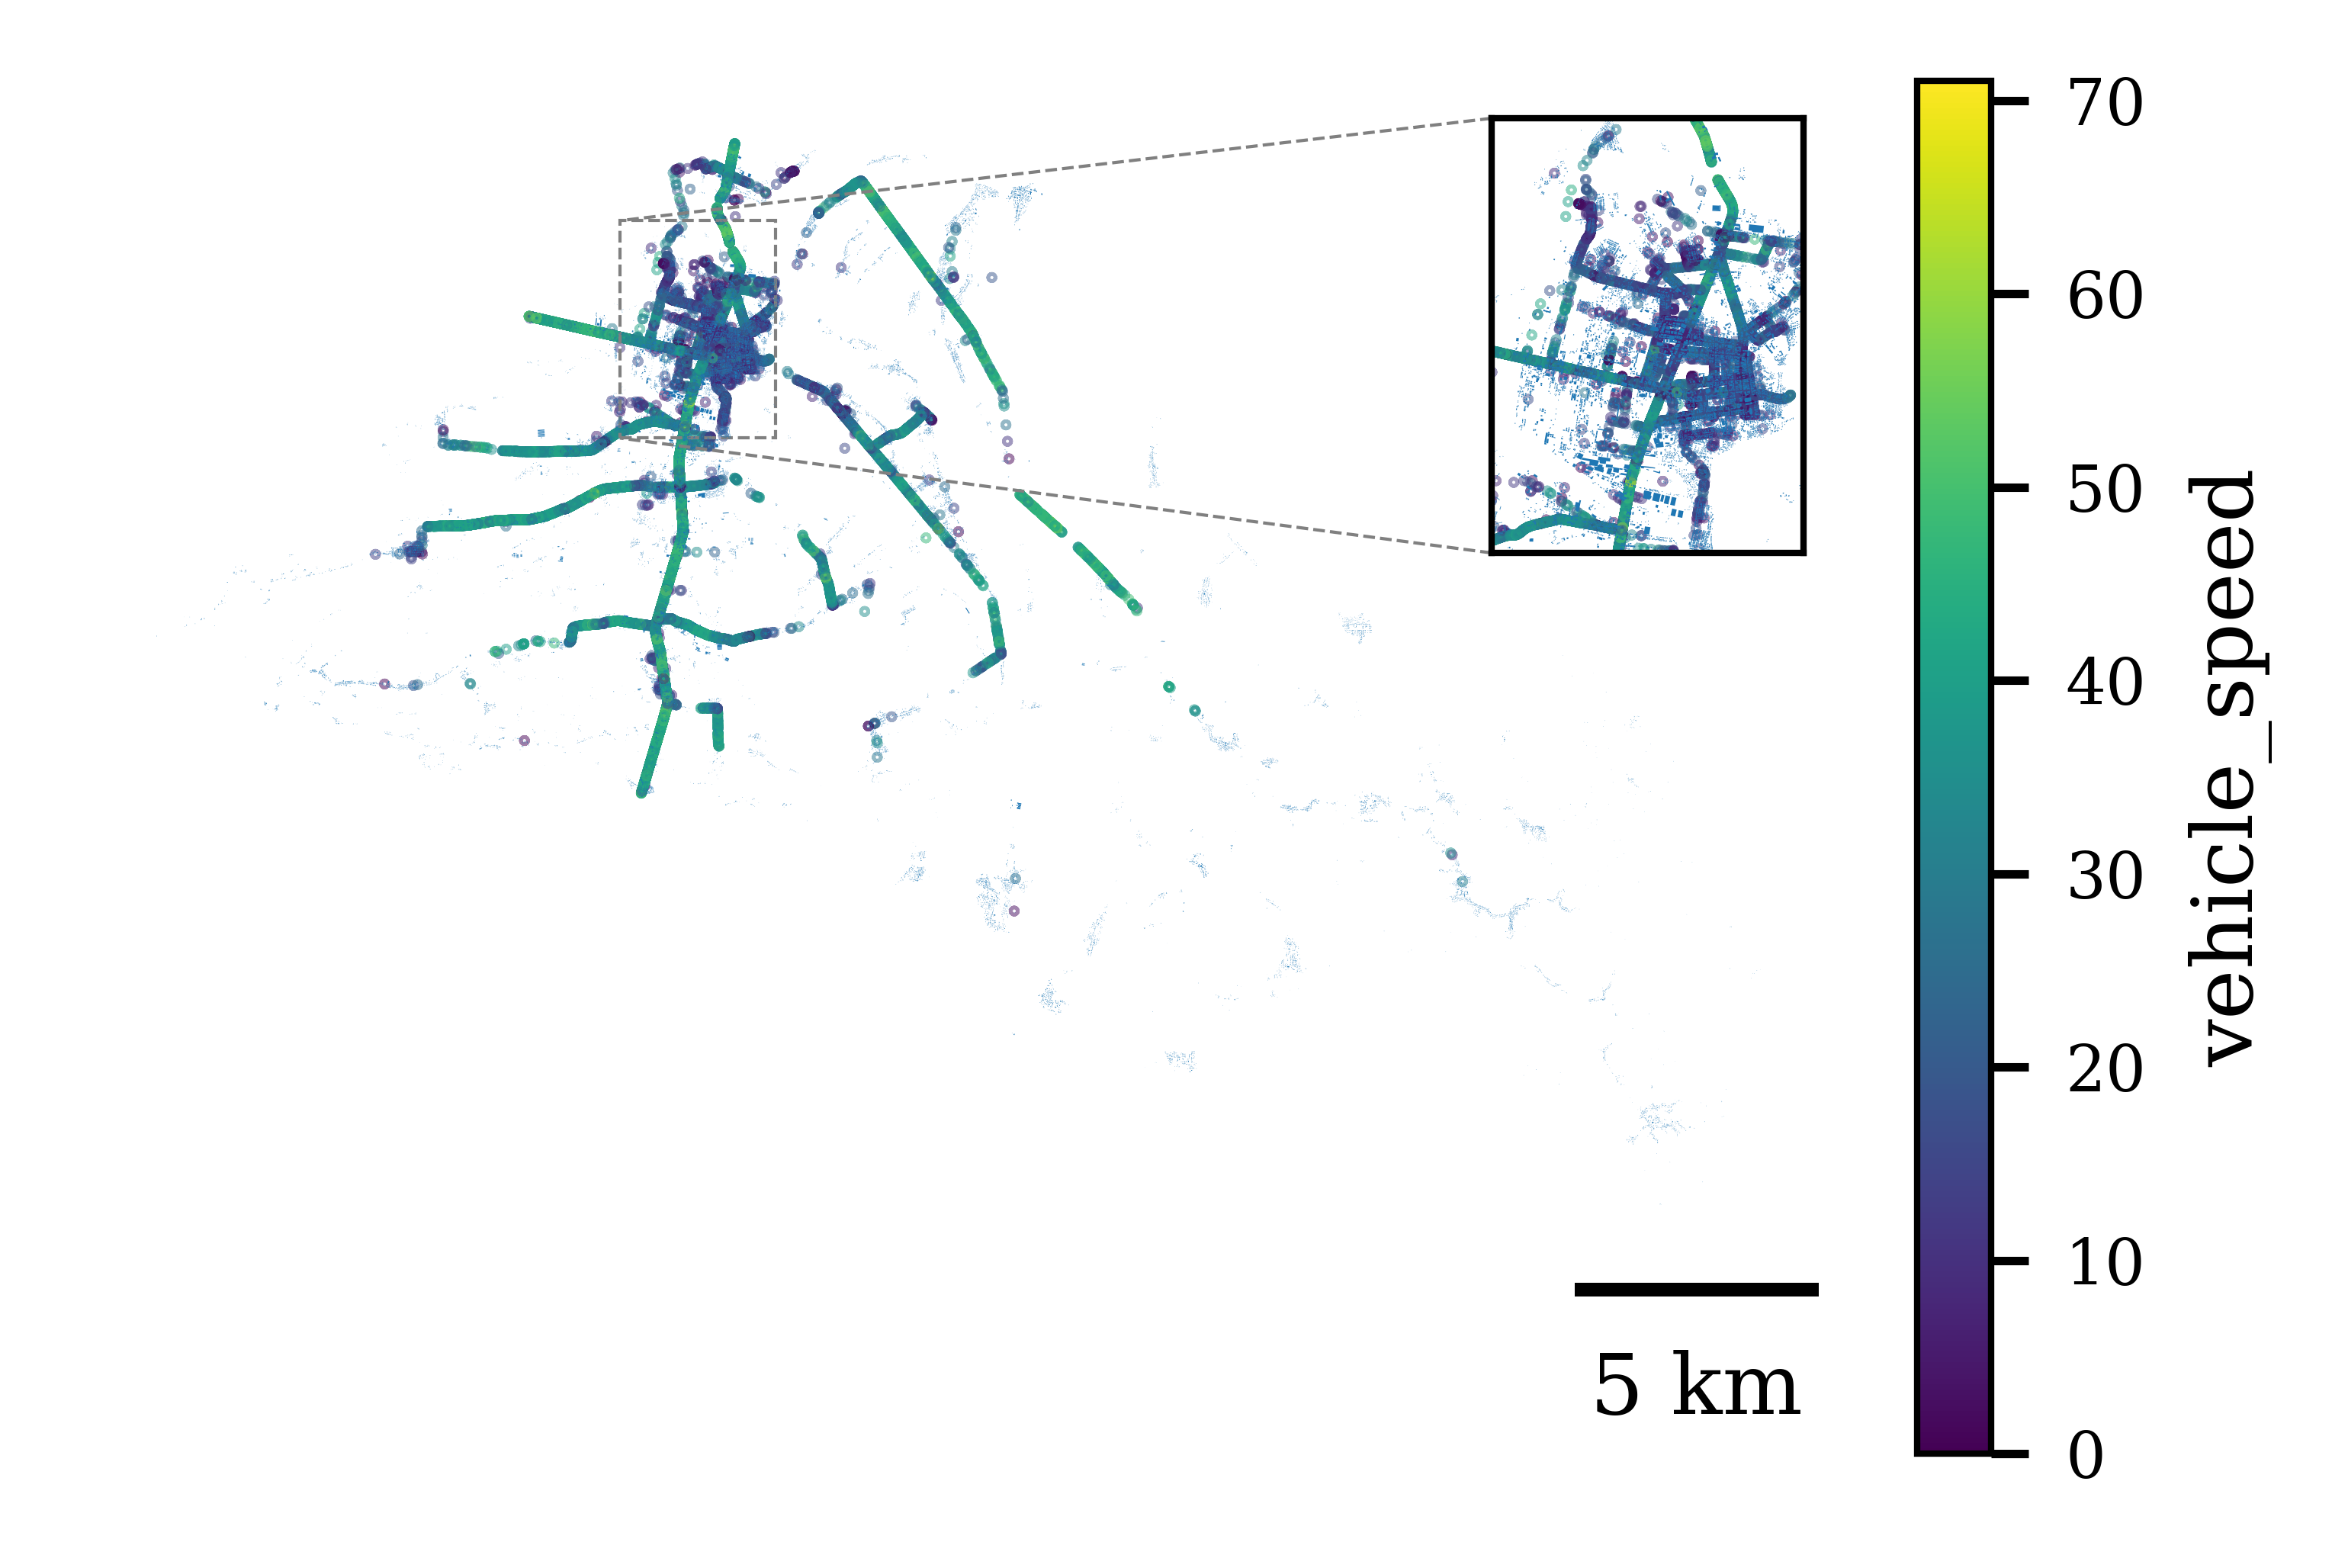

In [30]:
fig, ax = plt.subplots(1)
ax, axins = value_map_plot(data, ax, column='vehicle_speed', label='vehicle speed (km/hr)', plt_kws=plt_kws)
footprints.plot(ax=ax)
footprints.plot(ax=axins)

In [10]:
# footprints.plot(ax=ax)
# footprints.plot(ax=axins)

# fig

<AxesSubplot:>

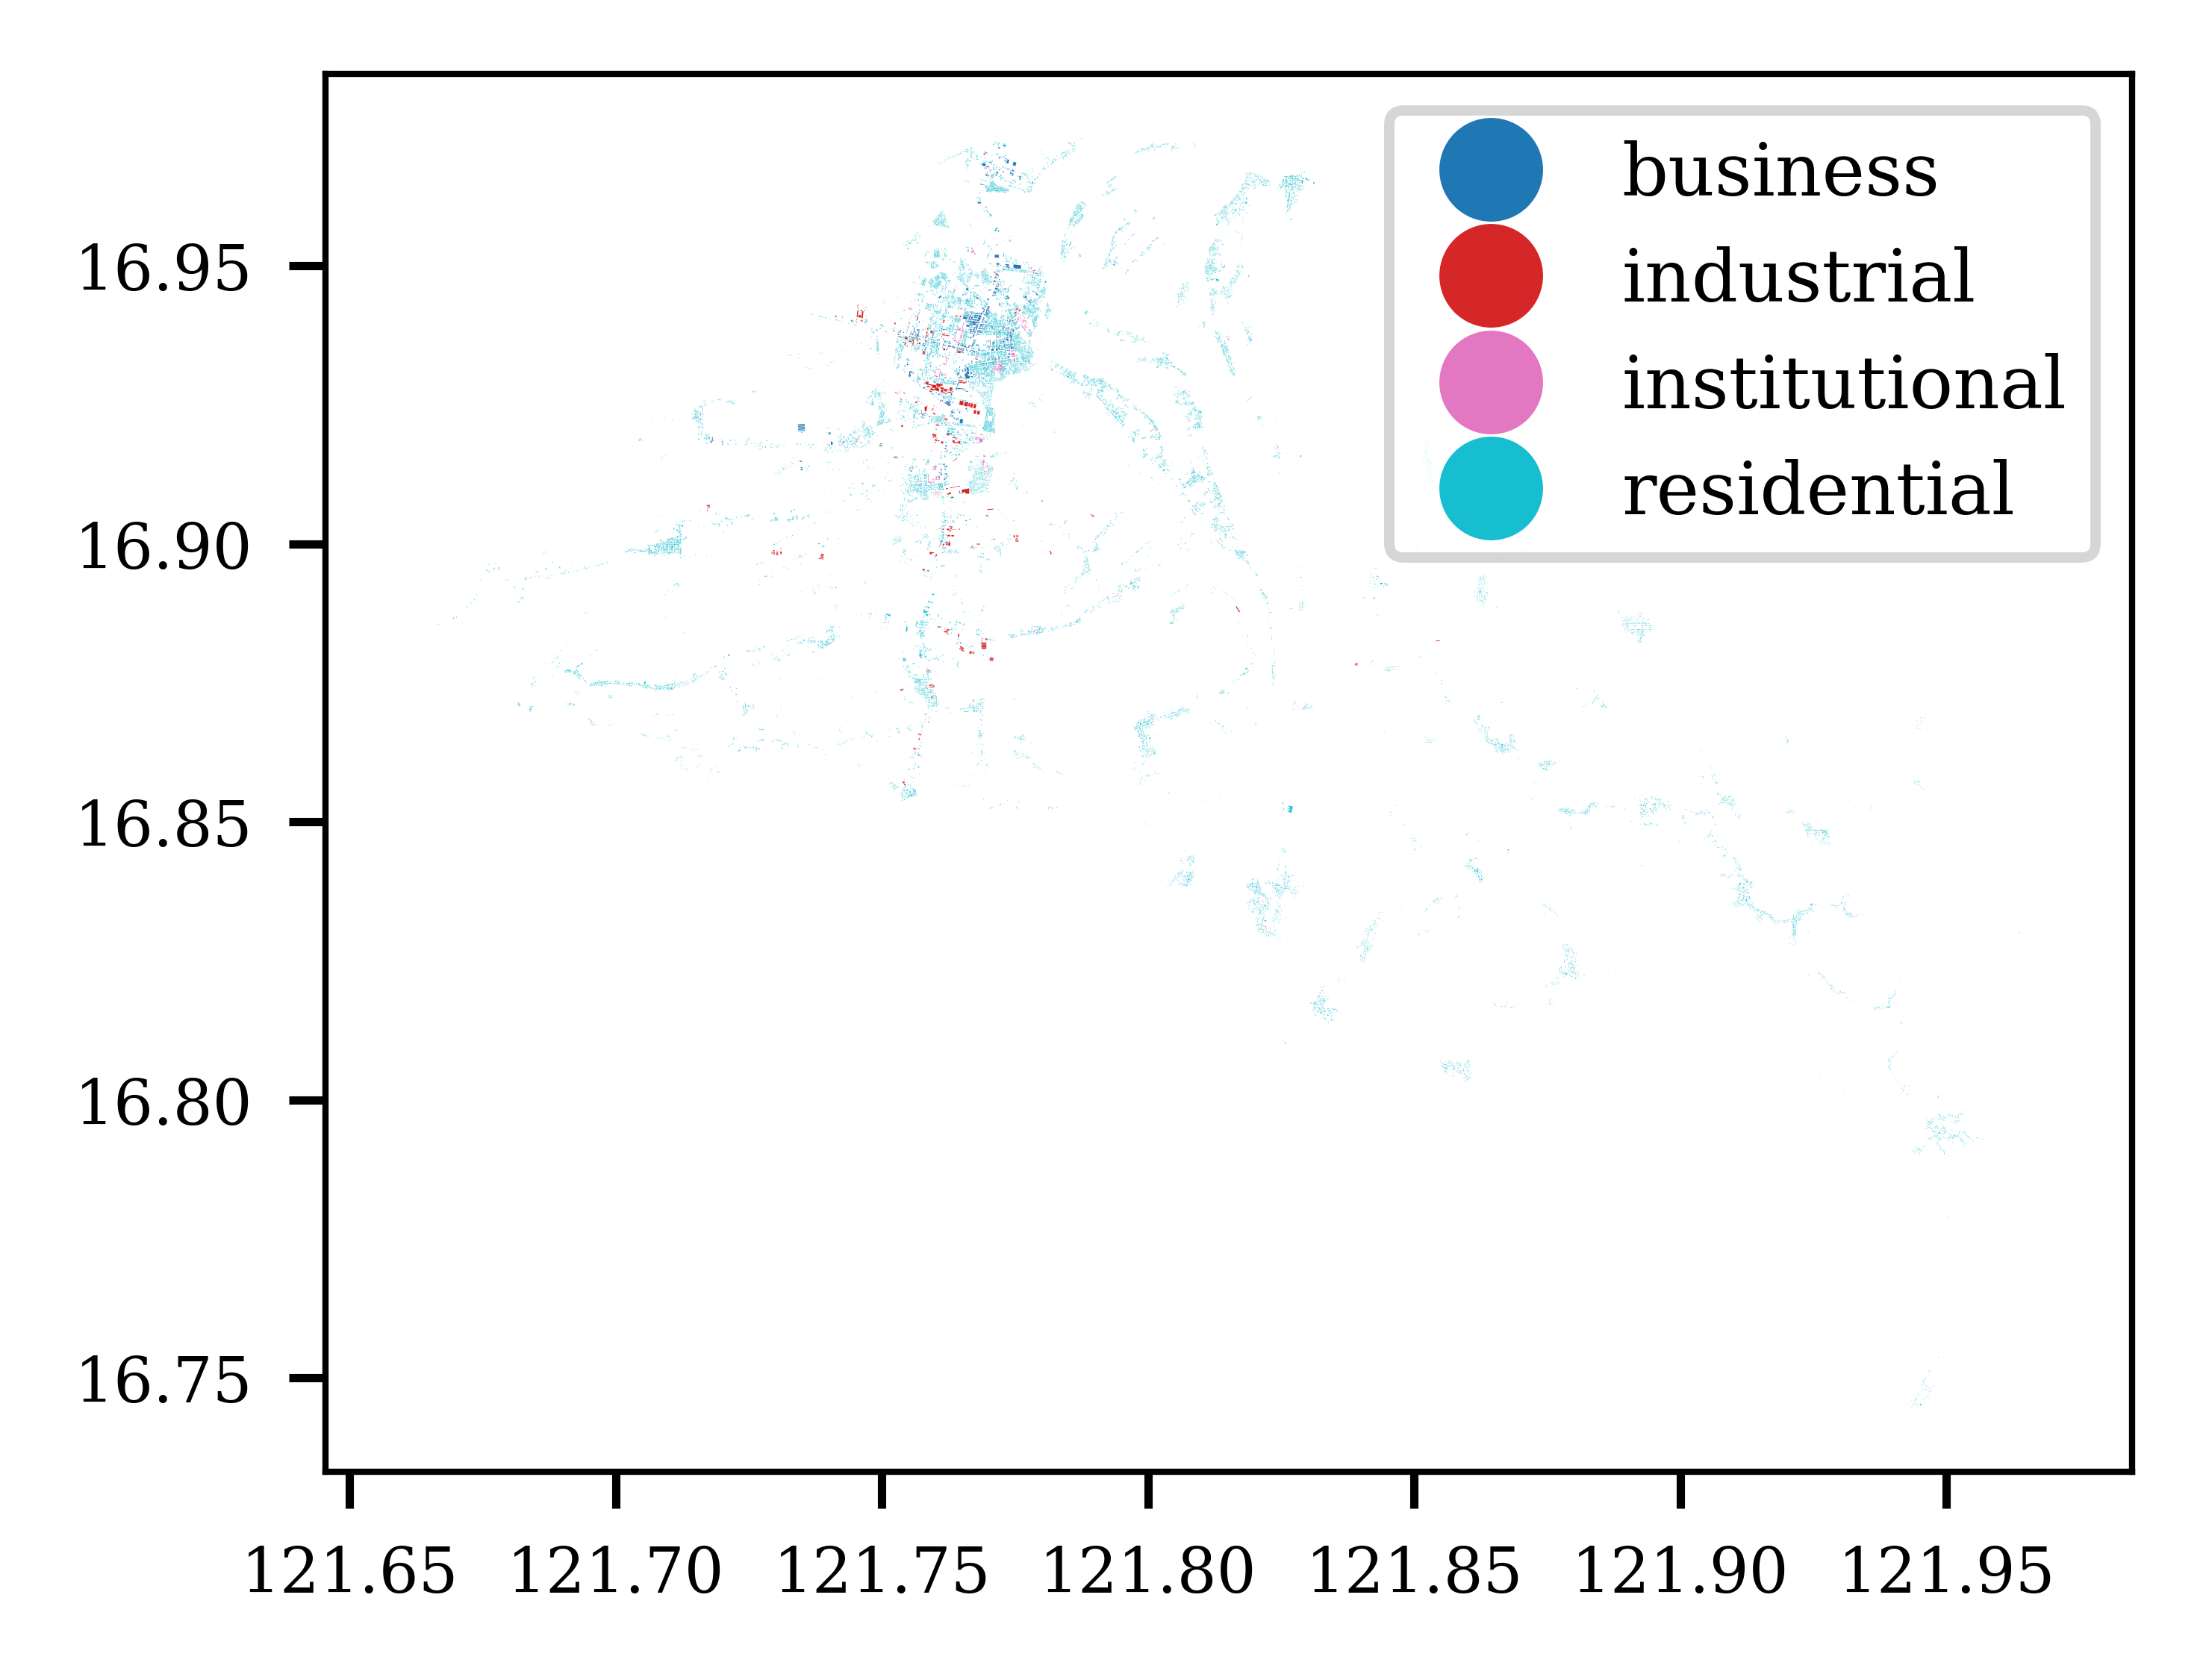

In [40]:
footprints.plot(column='Bldg_Class', legend=True)